In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [2]:
#%matplotlib notebook

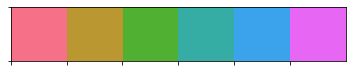

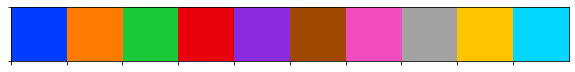

In [3]:
import seaborn as sns

NESTS = ['E1', 'E2', 'E3', 'E4', 'E5', 'U1', 'U2', 'U3', 'U4', 'U5']
POSTNATALDAYS = [1, 2, 4, 5, 9, 10]
MOTHERS = ['E', 'U']

POSTNATALDAYPALETTE = sns.husl_palette(n_colors=len(POSTNATALDAYS), h=0.01, s=0.9, l=0.65)
NESTPALETTE = sns.color_palette("bright", n_colors=len(NESTS), desat=1)

COLORS = {
    'vocalization': {
        1: 'tab:blue',
        2: 'tab:orange'
    },
    'postnatalday': dict(zip(POSTNATALDAYS, POSTNATALDAYPALETTE)),
    'nest': dict(zip(NESTS, NESTPALETTE)),
    'mother': {
        'E': '#FFFF00',  # yellow
        'U': '#FF8C00'  # orange
    },
    'year':{
        17: "purple",
        19: 'green'
    }
}

sns.palplot(POSTNATALDAYPALETTE)
sns.palplot(NESTPALETTE)

In [4]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.cluster as sc
from sklearn.metrics import (
    davies_bouldin_score,
    calinski_harabasz_score,
    silhouette_score
)

SEED = 666

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sns.set_style('white')

from audiovocana.conf import (FFTFREQS, MELFREQS)
from audiovocana.dataset import get_dataset

PLOT = True
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/usv-experiments/full-dataset/results"
YEAR = 19
VOCALIZATION = 1

/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


~~~~~~ AUDIOVOCANA SETTINGS ~~~~~~
AUDIOPARAMS 
 {'sr': 250000, 'mono': True}
STFTPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'win_length': 8192, 'center': True, 'window': 'hann'}
SPECTRALCENTROIDPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None}
SPECTRALBANDWIDTHPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None, 'centroid': None, 'norm': True, 'p': 2}
SPECTRALFLATNESSPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'amin': 1e-10, 'power': 2.0}
ZEROCRPARAMS 
 {'frame_length': 2048, 'hop_length': 512, 'center': True}
MELPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'n_mels': 128, 'fmin': 0, 'fmax': 125000.0, 'htk': True}
MFCCPAMARS 
 {'sr': 250000, 'n_mfcc': 13, 'dct_type': 2, 'norm': 'ortho', 'htk': True}
mel fiterbank shape = (128, 4097)
Minimun waveform length accepted is 4104 PCM points.
Minimun audio duration accepted is 16.416 miliseconds.
STFT time resolution = 32.768 ms.
STFT frequency resolution = 30.5101293629485 Hz.


In [5]:
csv_path = '/home/utilisateur/Desktop/palomars/data/full/dataset.csv'
cache_folder = '/home/utilisateur/Desktop/palomars/cache/full_dataset'

In [6]:
dataset = get_dataset(
    csv_path=csv_path,
    cache_folder=cache_folder,
    shuffle=False,
    recompute=False
)

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


# Filters

In [7]:
dataset = dataset.filter(lambda sample: sample['vocalization'] == VOCALIZATION)
dataset = dataset.filter(lambda sample: sample['year'] == YEAR)

In [8]:
vocs = []
postnataldays = []
recordings = []
mothers = []
nests = []

for sample in iter(dataset):
    vocs.append(sample['vocalization'].numpy())
    postnataldays.append(sample['postnatalday'].numpy())
    recordings.append(sample['recording'].numpy())
    mothers.append(sample['mother'].numpy().decode())
    nests.append( str(sample['nest'].numpy().decode()))

In [9]:
print(f"Nb audibles = {np.sum([v for v in vocs if v == 1])}")
print(f"Nb USVs = {np.sum([v for v in vocs if v == 2])}")
print(f"Audible events represents the {100 * np.sum([v for v in vocs if v == 1])/len(vocs)}% of total.")

Nb audibles = 1005
Nb USVs = 0.0
Audible events represents the 100.0% of total.


In [10]:
colors_vocs = pd.DataFrame(vocs)[0].map(COLORS['vocalization'])
colors_mother = pd.DataFrame(mothers)[0].map(COLORS['mother'])
colors_nest = pd.DataFrame(nests)[0].map(COLORS['nest'])
colors_pnds = pd.DataFrame(postnataldays)[0].map(COLORS['postnatalday'])
dicc_recordings =  dict(zip(
        set(recordings),
        sns.light_palette(COLORS['year'][YEAR], len(set(recordings)))))
colors_recordings = pd.DataFrame(recordings)[0].map(dicc_recordings)
colors = pd.concat([colors_vocs, colors_mother, colors_pnds, colors_nest, colors_recordings], axis=1)
colors.columns = ['vocalization', 'mother',  'postnatalday', 'nest',  'recording']

Text(0.5, 1.0, 'VOCALIZATION TYPE')

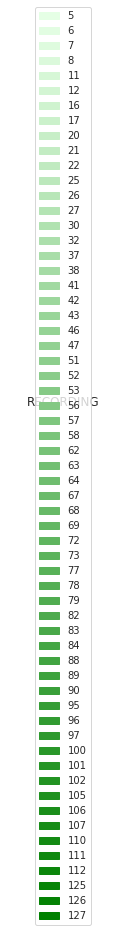

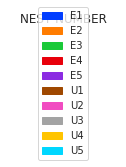

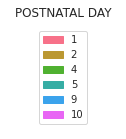

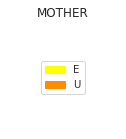

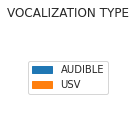

In [11]:
def plot_legend(colordicc, title):
    legend_elements = [Patch(facecolor=c, edgecolor=c, label=l) for l, c in colordicc.items()]
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.legend(handles=legend_elements, loc='center')
    plt.title(title)
    plt.axis('off')

plot_legend(dicc_recordings, 'RECORDING')
plot_legend(COLORS['nest'], 'NEST NUMBER')
plot_legend(COLORS['postnatalday'], 'POSTNATAL DAY')
plot_legend(COLORS['mother'], 'MOTHER')


legend_elements = [
    Patch(facecolor='tab:blue', edgecolor='tab:blue', label='AUDIBLE'),
    Patch(facecolor='tab:orange', edgecolor='tab:orange', label='USV')
]
fig, ax = plt.subplots(figsize=(2, 2))
ax.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.title('VOCALIZATION TYPE')

In [12]:
feats = dict()
for feat in ['mean_stft']:  #  ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 
    feats[feat] = np.array([sample[feat] for sample in tqdm(iter(dataset))])

1005it [00:18, 55.18it/s]


In [13]:
xlabels =  np.array([
    str(sample['experiment'].numpy().decode())+'_'+str(sample['event'].numpy())
    for sample in iter(dataset)
])

In [14]:
def get_ylabels(name, num):
    if name == 'stft':
        return [str(i)+' Hz' for i in np.linspace(FFTFREQS[0], FFTFREQS[-1], num=num, dtype=np.int)]
    elif name == '_mel':
        return [str(i)+' Hz' for i in np.linspace(MELFREQS[0], MELFREQS[-1], num=num, dtype=np.int)]
    elif name == 'mfcc':
        return np.linspace(0, num, num=num, dtype=np.int)


In [15]:
def hcluster(X, max_clusters, method, metric, colors, feat):

    g = sns.clustermap(
        pd.DataFrame(X),
        method=method,
        metric=metric,
        standard_scale=None, # Max-0 scaling. Either 0 (rows) or 1 (columns) or None
        z_score=0, # Whitening. Either 0 (by rows) or 1 (by columns) or None
        row_cluster=False,
        col_colors=colors,
        center=None, # check what this is, looks different with 0
        figsize=(16, 8),
        cbar_pos=None,
        xticklabels=1,
        yticklabels='auto')

    
    # linkage matrix
    Z = g.dendrogram_col.linkage
    for n in range(2, max_clusters+1):
        clusters_assignations = sc.hierarchy.fcluster(Z, t=n, criterion='maxclust')
        clusters = range(1, n+1)
        dicc_clusters =  dict(zip(
            clusters,
            sns.color_palette("cubehelix", n)))
        colors_clusters = pd.DataFrame(clusters_assignations)[0].map(dicc_clusters)

        tmp_colors = [f'{n}-clusters-labels'] + colors.columns.tolist()
        colors = pd.concat([colors_clusters, colors], axis=1)
        colors.columns = tmp_colors

    g = sns.clustermap(
        pd.DataFrame(X),
        method=method,
        metric=metric,
        standard_scale=None, # Max-0 scaling. Either 0 (rows) or 1 (columns) or None
        z_score=0, # Whitening. Either 0 (by rows) or 1 (by columns) or None
        row_cluster=False,
        col_colors=colors,
        center=None, # check what this is, looks different with 0
        figsize=(16, 8),
        cbar_pos=None,
        xticklabels=1,
        yticklabels='auto')
       
    for tick in g.ax_heatmap.axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
        tick.label.set_rotation('vertical')
        
             
    for tick in g.ax_heatmap.axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(2) 
        tick.label.set_rotation('horizontal')

    g.ax_heatmap.axes.set_yticklabels(
        get_ylabels(
            name=feat[-4:],
            num=len(g.ax_heatmap.axes.yaxis.get_major_ticks())
        )
    )
    
    return g

mean_stft-ward-euclidean-clustermap-FULL-1-19


/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


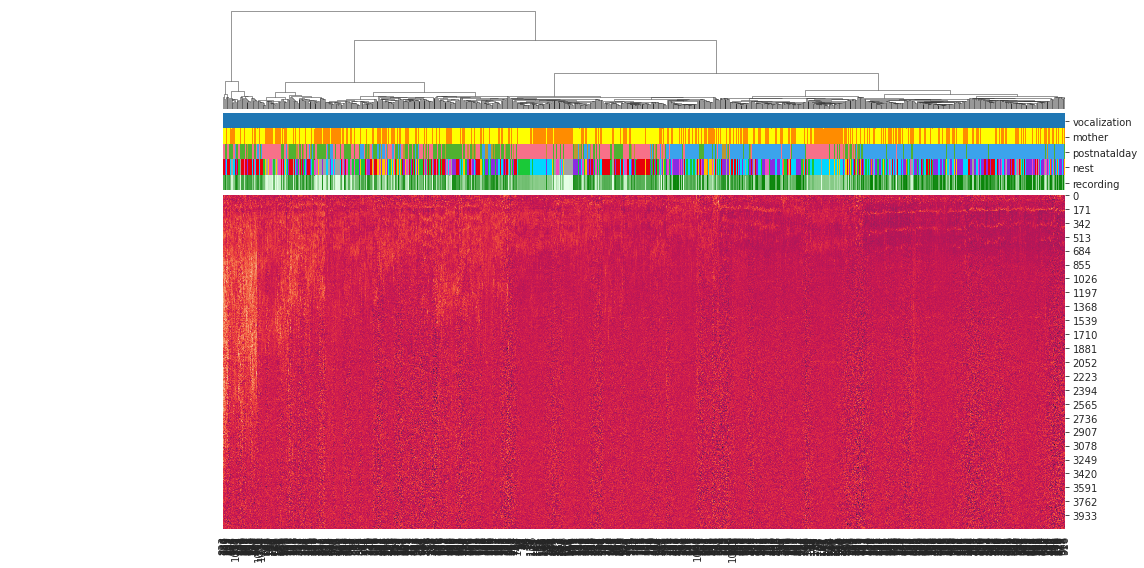

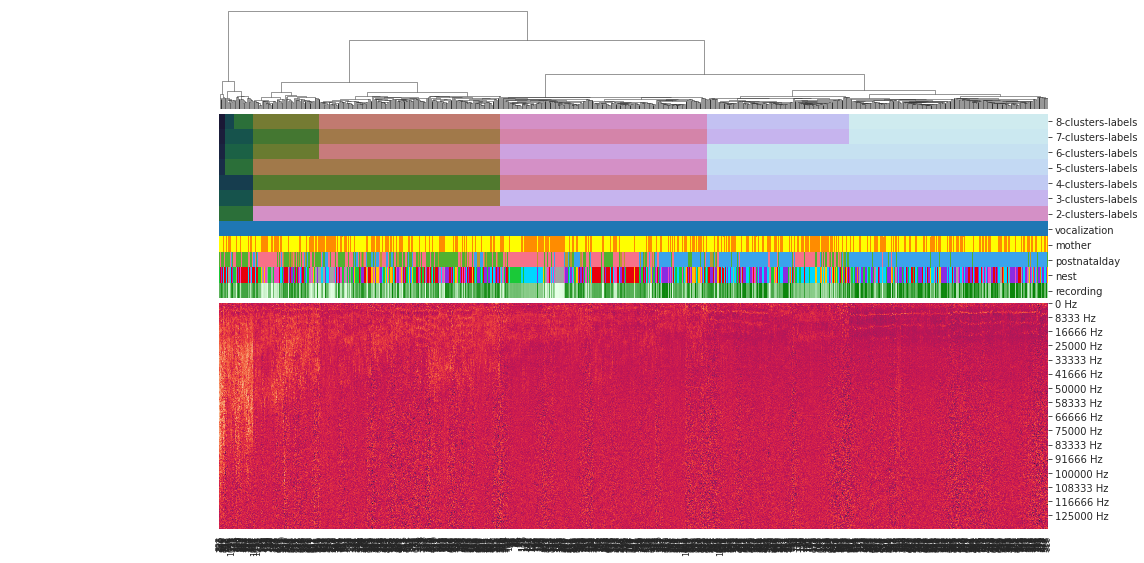

In [16]:
# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
# https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

AFFINITIES = ["euclidean"]  # ["euclidean", "cosine",  "sqeuclidean", "cityblock"]
LINKAGES = ["ward"]  # ["complete", "average", "single"] # ["ward"]
FEATS = ['mean_stft']  # ['max_mfcc', 'mean_mfcc', 'mean_mel', 'max_mel', 'mean_stft', 'max_stft']


for feat in FEATS:
    for linkage in LINKAGES:
        for metric in AFFINITIES:
    
            figtitle = f"{feat}-{linkage}-{metric}-clustermap-FULL-{VOCALIZATION}-{YEAR}"
            print(figtitle)
            
            X = feats[feat].T
        
            g = hcluster(X, 8, linkage, metric, colors, feat)
            # g.savefig(os.path.join(RESULTS_FOLDER, f"{figtitle}.png"))
            #cluster_index = xlabels[g.dendrogram_col.reordered_ind]

# Perform flat clustering

In [17]:
Z = g.dendrogram_col.linkage
results = []
for n_clusters in range(2, 10):
    labels = sc.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')
    results.append({
        "n_clusters": n_clusters,
        "Calinski-Harabasz score": calinski_harabasz_score(X.T, labels),
        "Davies-Bouldin score": davies_bouldin_score(X.T, labels),
        "Silhouette Coefficient": silhouette_score(X.T, labels),
})

In [19]:
data = pd.DataFrame.from_records(results)

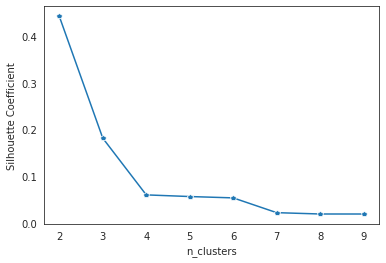

In [20]:
ax = sns.lineplot(x='n_clusters', y='Silhouette Coefficient', data=data, marker='p')

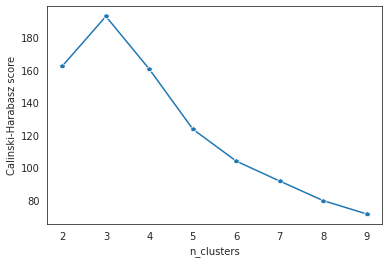

In [21]:
ax = sns.lineplot(x='n_clusters', y='Calinski-Harabasz score', data=data, marker='p')

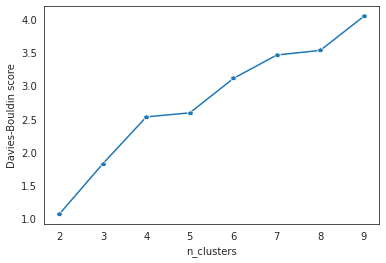

In [22]:
ax = sns.lineplot(x='n_clusters', y='Davies-Bouldin score', data=data, marker='p')